In [65]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
from math import ceil
import matplotlib.patches as patches

In [2]:
DATA = Path("..","data","processed")
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical\nand Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very\nLow",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [22]:
def get_scenario_name(emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> str:
    if not (sector or price):
        return f"er{emission}"
    else:
        return f"{sector}dr-{price}-er{emission}" 

In [31]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    scenario = get_scenario_name(emission=emission, sector=sector, price=price)
    p = Path(DATA, scenario, "dataframe", f"{result}.csv")
    return pd.read_csv(p)

In [34]:
def get_ldc(emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.Series:
    scenario = get_scenario_name(emission=emission, sector=sector, price=price)
    df = get_dataframe(emission=emission, sector=sector, price=price, result="peakiness")
    return df[["Net_Load_MW"]].rename(columns={"Net_Load_MW":scenario}).squeeze().sort_values(ascending=False)

In [114]:
def get_data() -> dict[str,pd.DataFrame]:
    data = {}
    for emission in EMISSIONS:
        dfs = []
        dfs.append(get_ldc(emission).to_frame(name="base"))
        for sector, price in product(SECTORS, PRICES):
            df = get_ldc(emission, sector, price).to_frame()
            dfs.append(df)
        data[f"er{emission}"] = pd.concat(dfs, axis=1)
    return data

In [116]:
def generate_ldc(emission: str, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    data = get_data()
    
    ncols = 2
    nrows = 1
    
    color_map = {
        "base": "k",
        "Edr": "tab:purple", 
        "Hdr": "tab:orange", 
        "EHdr": "tab:green", 
    }

    linestyle_map = {
        "base": "-",
        "high": "-",
        "mid": "--",
        "low": "-.",
        "vlow": ":",
    }

    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
    
    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)
    
    df = data[emission]
    
    upper = df.max().max()
    lower = df.max().min()
    
    for col in df.columns:
        
        if col == "base":
            sector = "base"
            price = "base"
            label = "No DR"
        else:
            sector = col.split("-")[0]
            price = col.split("-")[1]
            label = f"{sector}-{price}"
        
        color = color_map[sector]
        linestyle = linestyle_map[price]
    
        df[col].plot(ax=axs[0], label=label, color=color, linestyle=linestyle)
        df[col].plot(ax=axs[1], xlim=(0,100), ylim=(lower-2000, upper+2000), label=label, color=color, linestyle=linestyle)
        
    
    rectangle = patches.Rectangle(
        (-300, lower-4000),  # (x, y) of bottom-left corner
        600,         # Width of the rectangle
        (upper + 2000) - (lower - 4000),       # Height of the rectangle
        linewidth=2, 
        edgecolor='red', 
        facecolor='none',
        zorder=99
    )
    axs[0].add_patch(rectangle)
    
    
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles, 
        labels, 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),  # Position to the right of the figure
        ncol=1, 
        frameon=False,
    )
    
    fig.suptitle(f"{emission[-2:]}% Emission Reduction Net Load Duration Curve", fontsize=20)
    fig.supxlabel("Hour of Year")
    fig.supylabel("Net Load (MW)")
        
    plt.tight_layout(rect=[0, 0, 1, 0.99])
        
    return fig, axs

(<Figure size 1200x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

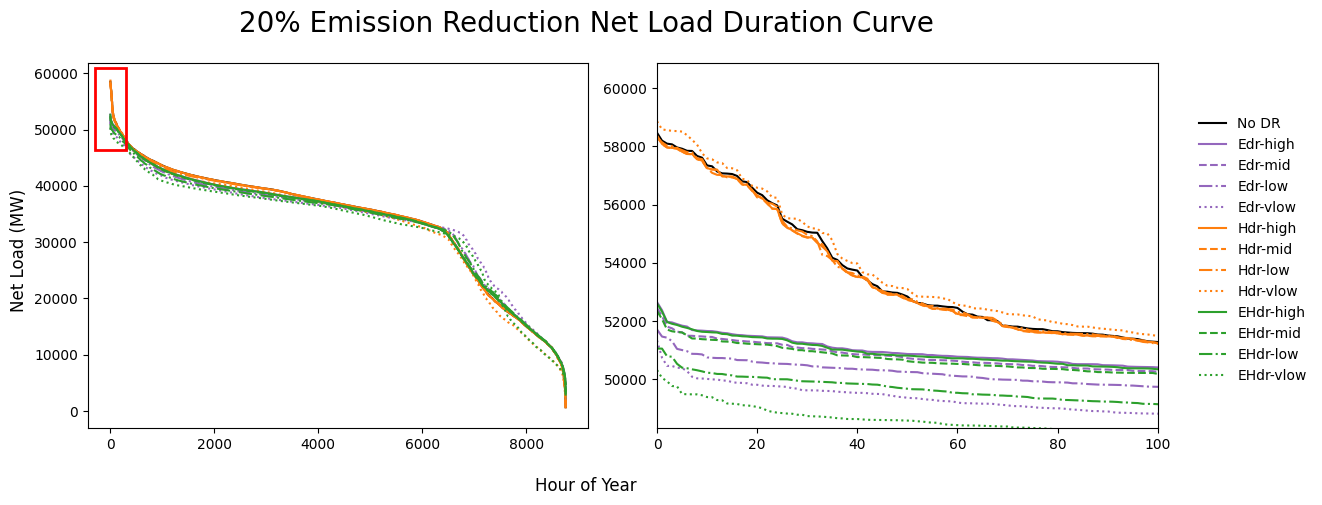

In [117]:
generate_ldc("er20")

(<Figure size 1200x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

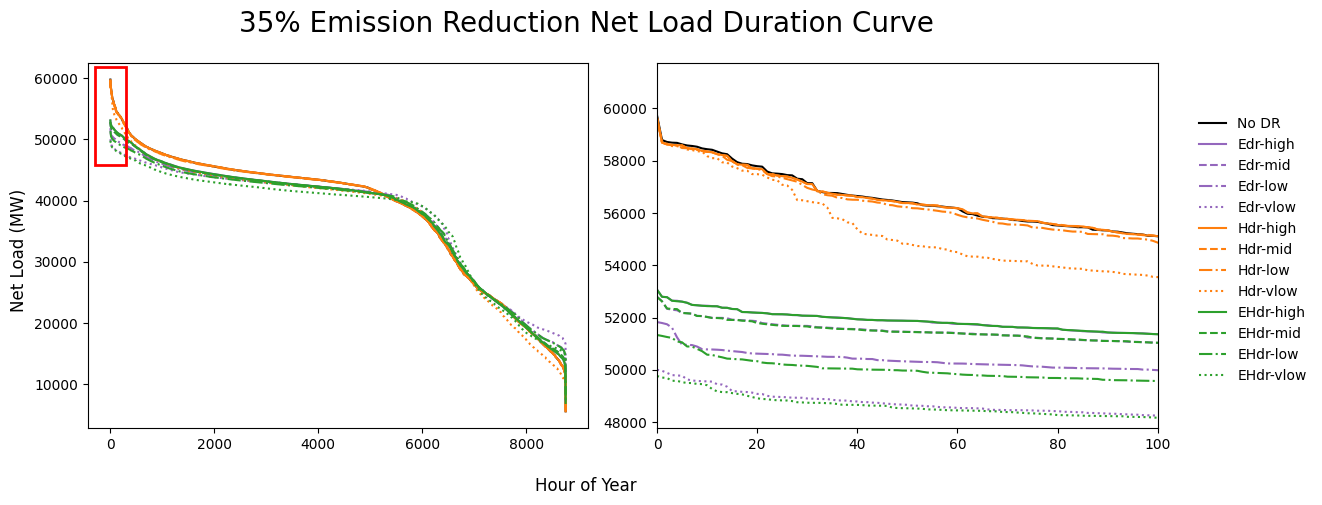

In [118]:
generate_ldc("er35")

(<Figure size 1200x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

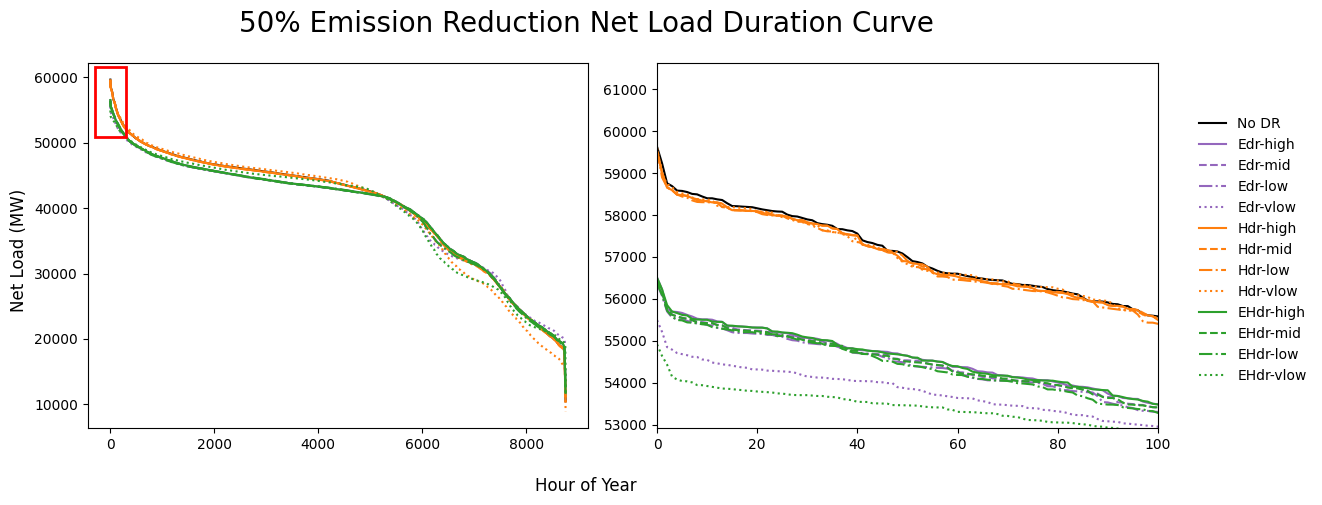

In [119]:
generate_ldc("er50")